In [ ]:
%%html
<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt
import sys
import datetime

#If module is not found, downloads it to root folder (ignored by git)
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    
    try:
        sys.path.append('../covid19_inference-model_cleanup')
        import covid19_inference as cov19
        
    except ModuleNotFoundError:
        url_repo = "https://github.com/Priesemann-Group/covid19_inference/archive/model_cleanup.zip"

        import requests, zipfile, io
        r = requests.get(url_repo)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(path="..")
        sys.path.append('../covid19_inference-model_cleanup')
        import covid19_inference as cov19

## Loads data

In [3]:
#Data dates
bd = datetime.datetime(2020,3,2)
ed = datetime.datetime(2020,4,21)

#Downloads data from built-in sources
new_cases_rki = cov19.data_retrieval.RKI(True).get_new(value="confirmed", data_begin=bd, data_end=ed)
new_cases_rki_ref = cov19.data_retrieval.RKI(True).get_new(value="confirmed", data_begin=bd, data_end=ed, date_type='date_ref')
new_cases_jhu = cov19.data_retrieval.JHU(True).get_new(value='confirmed', country='Germany', data_begin=bd, data_end=ed)
new_cases_owd = cov19.data_retrieval.OWD(True).get_new(value='confirmed', country='Germany', data_begin=bd, data_end=ed)

#Gets RKI cases just for the cases with known onset date (~60%)
data_rki = cov19.data_retrieval.RKI(True)
data_rki.data = data_rki.data[data_rki.data.date != data_rki.data.date_ref]
new_cases_rki_ref_only = data_rki.get_new(value="confirmed", data_begin=bd, data_end=ed, date_type='date_ref')

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local
INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local
INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local
INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local
INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local


## Defines model and plotting

In [4]:
#Defines the exact same model to be run with different timeseries
def model_paper(new_cases, bd, ed, cores=4, draws=500):
    
    #Parameters
    diff_data_sim = 16 
    num_days_forecast = 10
    
    # We set the prior changepoints here
    prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
    prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
    prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)
    
    change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                            pr_sigma_date_transient = 3,
                            pr_median_lambda = 0.2,
                            pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                            pr_sigma_date_transient = 1.5,
                            pr_median_lambda = 1/8,
                            pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                            pr_sigma_date_transient = 1.5,
                            pr_median_lambda = 1/8/2,
                            pr_sigma_lambda = 1)]
    
    params_model = dict(new_cases_obs = new_cases,
                                        data_begin = bd,
                                        fcast_len = num_days_forecast,
                                        diff_data_sim = diff_data_sim,
                                        N_population = 83e6) 
    pr_delay = 10
    
    with cov19.model.Cov19Model(**params_model) as this_model:
        # Create the an array of the time dependent infection rate lambda
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,  # The change point priors we constructed earlier
            name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
        )

        # set prior distribution for the recovery rate
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

        # This builds a decorrelated prior for I_begin for faster inference.
        # It is not necessary to use it, one can simply remove it and use the default argument
        # for pr_I_begin in cov19.SIR
        prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log,
            mu=mu,
            pr_median_delay=pr_delay,
            name_I_begin="I_begin",
            name_I_begin_ratio_log="I_begin_ratio_log",
            pr_sigma_I_begin=2,
            n_data_points_used=5,
        )

        # Use lambda_t_log and mu to run the SIR model
        new_cases = cov19.model.SIR(
            lambda_t_log=lambda_t_log,
            mu=mu,
            name_new_I_t="new_I_t",
            name_I_t="I_t",
            name_I_begin="I_begin",
            pr_I_begin=prior_I,
        )

        # Delay the cases by a lognormal reporting delay
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            name_delay="delay",
            name_width="delay-width",
            pr_mean_of_median=pr_delay,
            pr_sigma_of_median=0.2,
            pr_median_of_width=0.3,
        )

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        new_cases = cov19.model.week_modulation(
            cases=new_cases,
            name_cases="new_cases",
            name_weekend_factor="weekend_factor",
            name_offset_modulation="offset_modulation",
            week_modulation_type="abs_sine",
            pr_mean_weekend_factor=0.3,
            pr_sigma_weekend_factor=0.5,
            weekend_days=(6, 7),
        )

        # Define the likelihood, uses the new_cases_obs set as model parameter
        cov19.model.student_t_likelihood(new_cases)
    
    #Runs the sampling
    trace = pm.sample(model=this_model, tune=500, draws=draws, cores=cores, init='advi+adapt_diag')
    
    return this_model, trace

def plot_distributions(model, trace, color=None):
    fig, axes = plt.subplots(6, 3, figsize=(8, 12))
    left_vars = ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
    mid_vars = ["offset_modulation","sigma_obs","I_begin","transient_day_1","transient_day_2","transient_day_3"]
    right_vars =  ["delay", "transient_len_1", "transient_len_2", "transient_len_3"]

    for i, key in enumerate(left_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i, 0], color=color)

    for i, key in enumerate(mid_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i, 1], color=color)

    for i, key in enumerate(right_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i + 2, 2], color=color)

    fig.tight_layout()

def plot_results(model, trace):
    cov19.plot.timeseries_overview(model, trace)
    plot_distributions(model, trace)


## Runs models

In [5]:
#Runs models
model_jhu, trace_jhu = model_paper(new_cases_jhu, bd,ed, cores=6)
model_rki, trace_rki = model_paper(new_cases_rki, bd,ed, cores=6)
model_rki_ref, trace_rki_ref = model_paper(new_cases_rki_ref, bd,ed, cores=6)
model_rki_ref_only, trace_rki_ref_only = model_paper(new_cases_rki_ref_only, bd,ed, cores=6)
model_owd, trace_owd = model_paper(new_cases_owd, bd,ed, cores=6)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

## Plots in order: JHU, RKI, RKI (onset), RKI (onset + unknown), ECDC

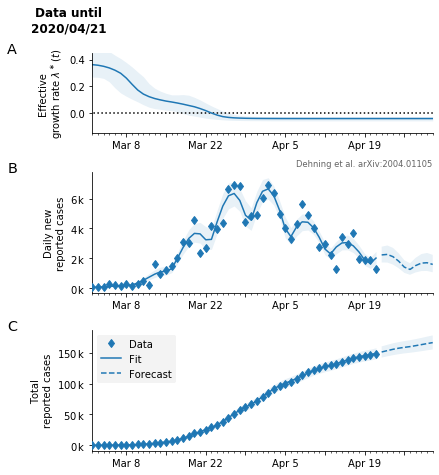

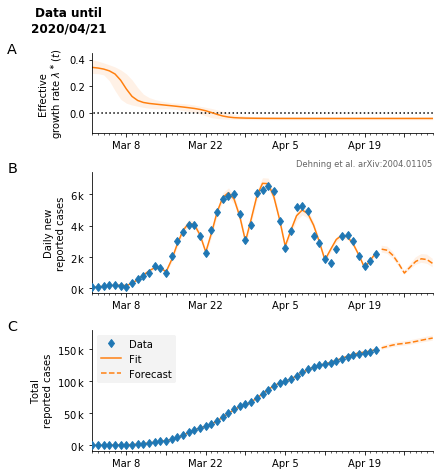

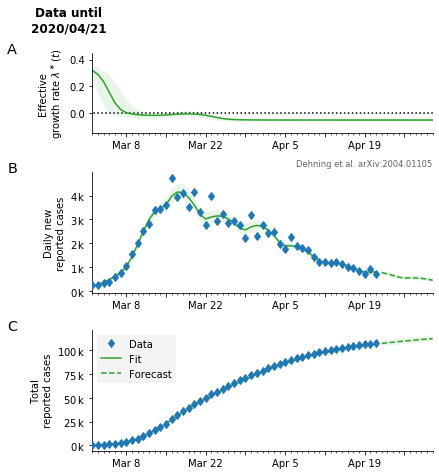

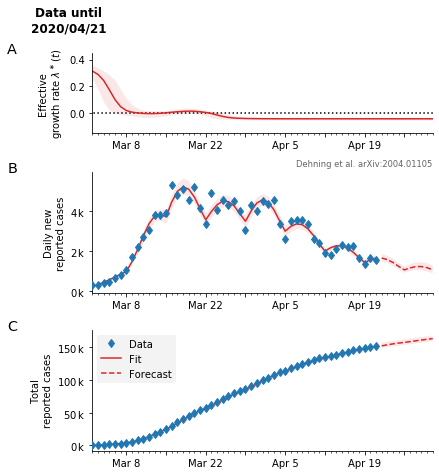

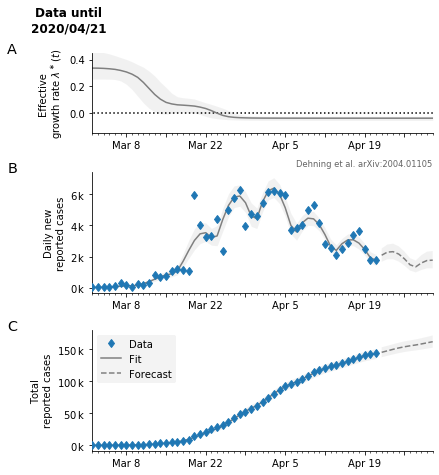

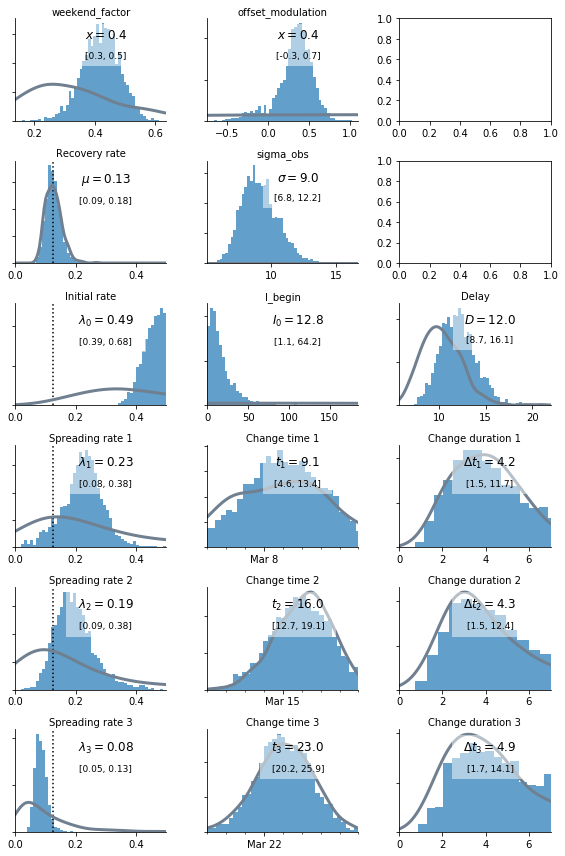

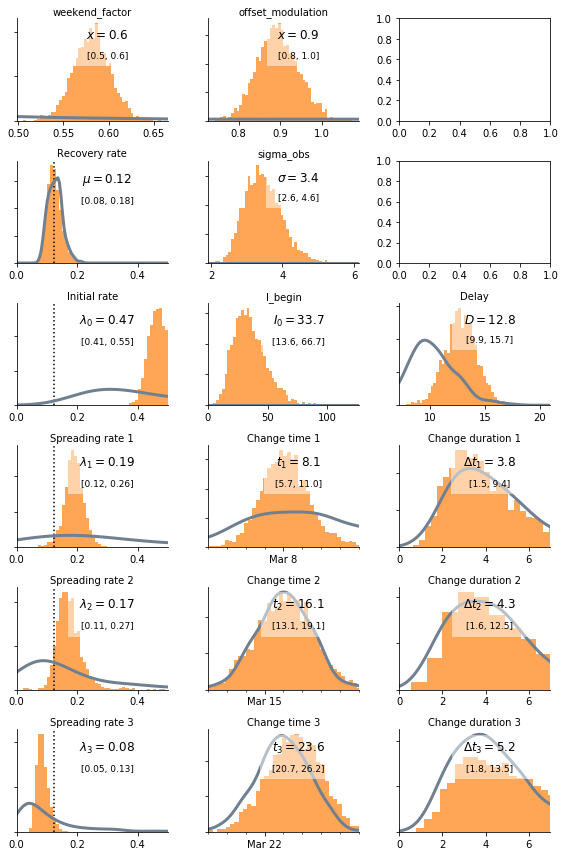

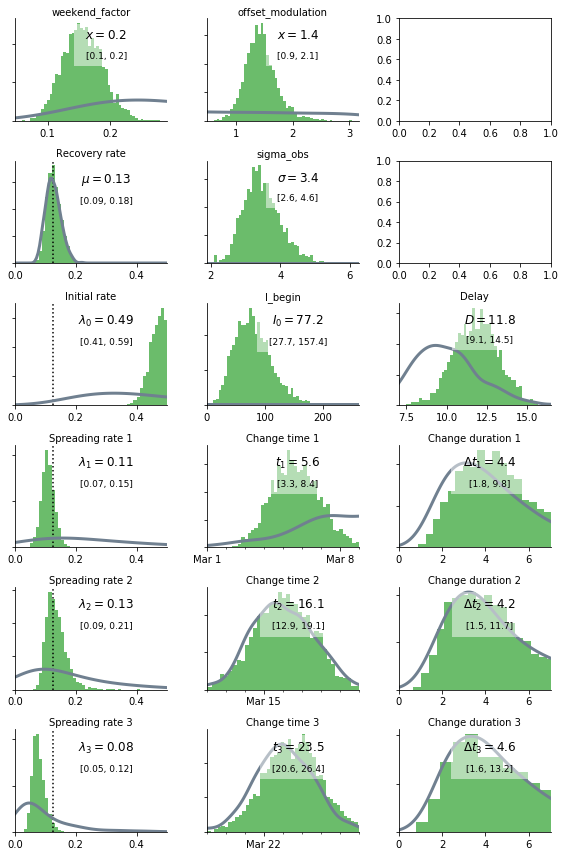

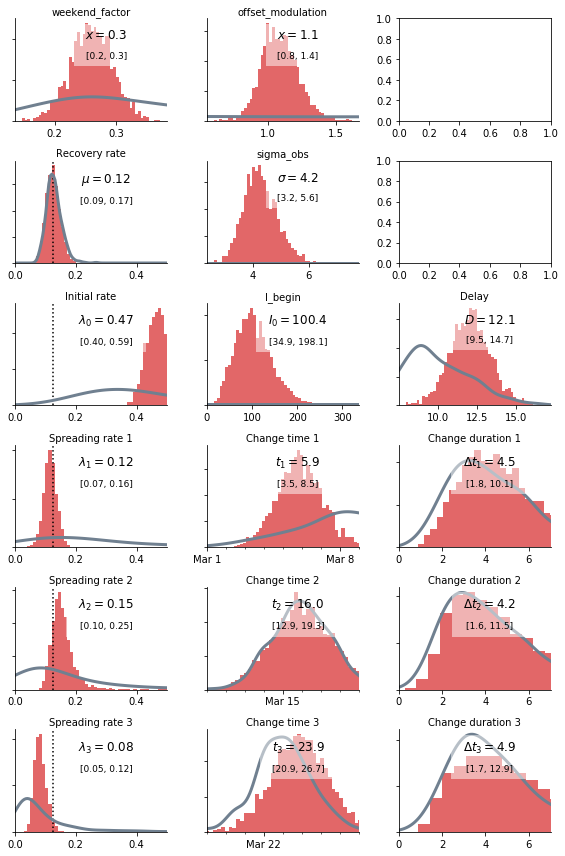

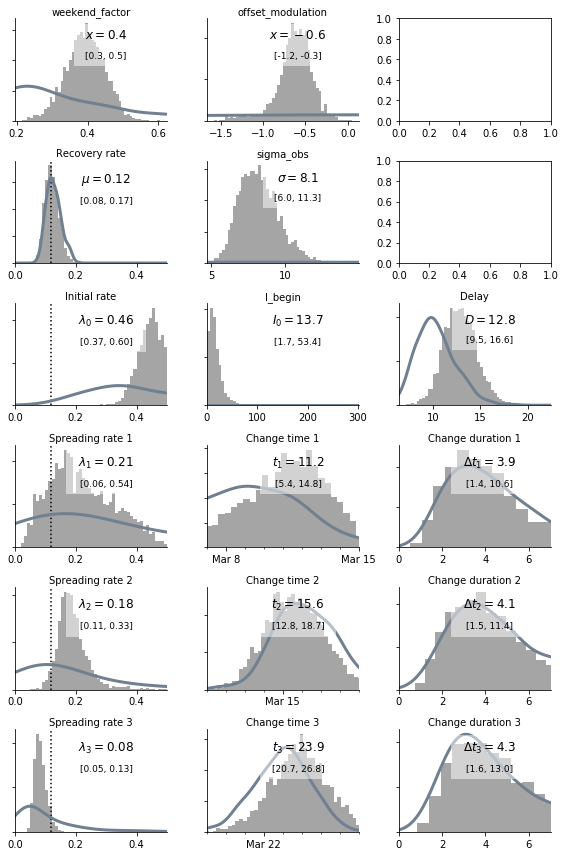

In [6]:
#Colors. In order: JHU, RKI, RKI (onset+unknown), ECDC
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:gray']

#Plots timeseries
cov19.plot.timeseries_overview(model_jhu, trace_jhu, color=colors[0])
cov19.plot.timeseries_overview(model_rki, trace_rki, color=colors[1])
cov19.plot.timeseries_overview(model_rki_ref_only, trace_rki_ref_only, color=colors[2])
cov19.plot.timeseries_overview(model_rki_ref, trace_rki_ref, color=colors[3])
cov19.plot.timeseries_overview(model_owd, trace_owd, color=colors[4])

#Plots distributions
plot_distributions(model_jhu, trace_jhu, color=colors[0])
plot_distributions(model_rki, trace_rki, color=colors[1])
plot_distributions(model_rki_ref_only, trace_rki_ref_only, color=colors[2])
plot_distributions(model_rki_ref, trace_rki_ref, color=colors[3])
plot_distributions(model_owd, trace_owd, color=colors[4])